#  Research Notebook: Adaptive Pairs Trading with Kalman Filters & EM Calibration

## 1. Abstract
This project implements a dynamic Statistical Arbitrage strategy. Unlike traditional pairs trading which relies on static cointegration tests (Engle-Granger), we treat the hedge ratio ($\beta$) as a time-varying parameter within a **Linear Gaussian State-Space Model**.

We utilize the **Kalman Filter** to recursively estimate this hidden state and the **Expectation-Maximization (EM)** algorithm for unsupervised parameter calibration, making the model robust to regime shifts without manual tuning.

## 2. Mathematical Framework
We model the relationship between Asset $Y$ (Target) and Asset $X$ (Reference) as a dynamic linear regression:

### Observation Equation (Measurement)
$$Y_t = \beta_t X_t + \alpha_t + \epsilon_t, \quad \epsilon_t \sim \mathcal{N}(0, R)$$
* We observe prices $Y_t$ and $X_t$.
* We infer the hidden states $\beta_t$ (Hedge Ratio) and $\alpha_t$ (Intercept).

### State Transition Equation (Dynamics)
We assume the parameters follow a Random Walk process:
$$\beta_t = \beta_{t-1} + \omega_{\beta,t}$$
$$\alpha_t = \alpha_{t-1} + \omega_{\alpha,t}$$
$$\omega \sim \mathcal{N}(0, \mathbf{Q})$$

### Calibration (EM Algorithm)
Instead of guessing the noise covariances $\mathbf{Q}$ and $R$, we maximize the likelihood of the observed data using the EM algorithm:
$$\hat{\theta}_{MLE} = \arg\max_{\theta} \mathcal{L}(\theta | Y_{1:T})$$

In [3]:


import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from pykalman import KalmanFilter


sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = (12, 6)
pd.options.mode.chained_assignment = None

[*********************100%***********************]  2 of 2 completed


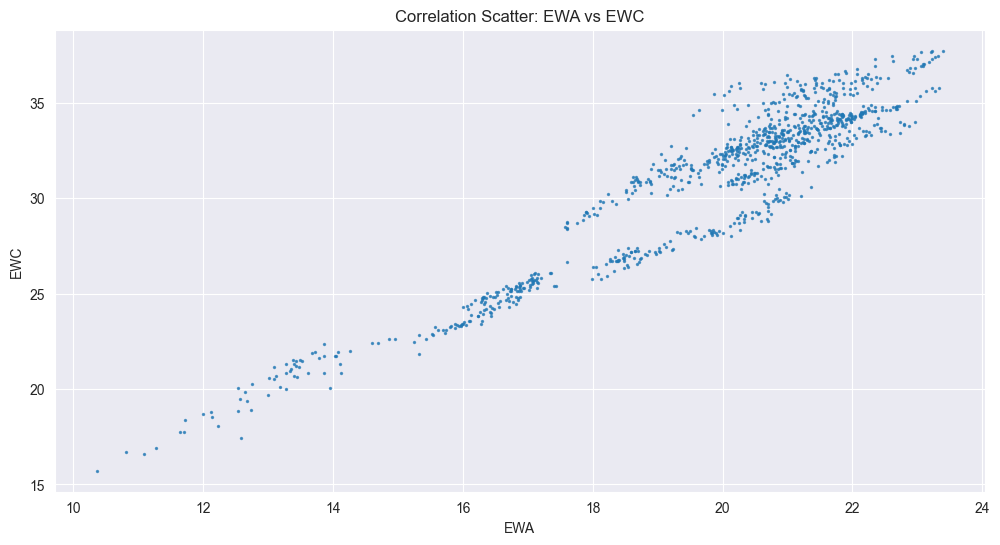

In [4]:
def get_market_data(tickers, start_date, end_date):

    raw_data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)
    
    
    if 'Adj Close' in raw_data.columns:
        df = raw_data['Adj Close']
    elif 'Close' in raw_data.columns:
        df = raw_data['Close']
    else:
        df = raw_data
    df = df.dropna()
    return df

ASSET_Y = 'EWC' # Canada ETF (Target)
ASSET_X = 'EWA' # Australia ETF (Reference)
START = '2020-01-01'
END = '2024-01-01'

# Execution
df = get_market_data([ASSET_Y, ASSET_X], START, END)
x = df[ASSET_X]
y = df[ASSET_Y]

# Visualize correlation
plt.scatter(x, y, s=2, alpha=0.7)
plt.title(f"Correlation Scatter: {ASSET_X} vs {ASSET_Y}")
plt.xlabel(ASSET_X)
plt.ylabel(ASSET_Y)
plt.show()

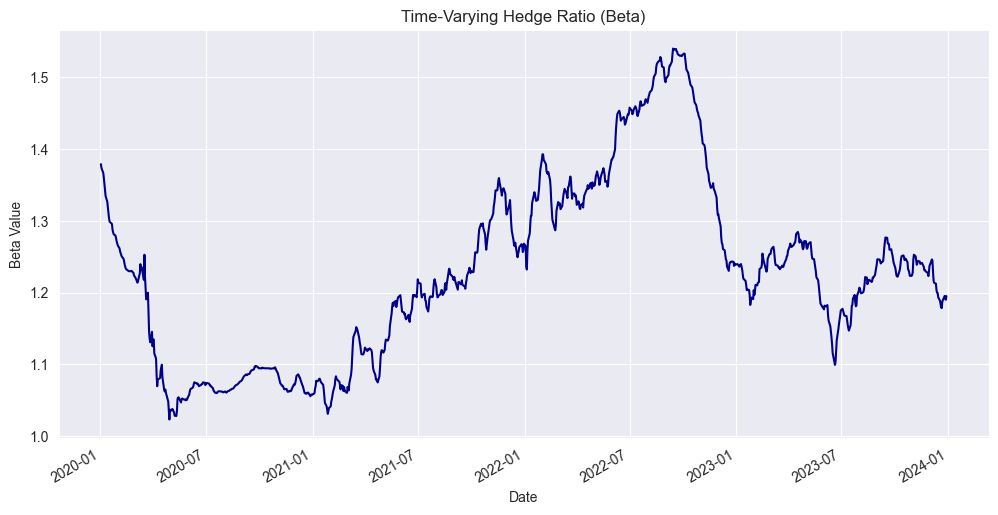

In [5]:
def run_kalman_regression(x, y, n_iter=5):
    """
    Estimates the dynamic Hedge Ratio (Beta) and Intercept (Alpha).
    Uses Expectation-Maximization (EM) to calibrate noise covariance matrices Q and R.
    """
    
    # y = beta*x + alpha*1
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)
    
    
    # 2 hidden states (Beta, Alpha) from 1 observation (Y)
    kf = KalmanFilter(
        n_dim_obs=1, 
        n_dim_state=2, 
        initial_state_mean=[0,0],
        initial_state_covariance=np.ones((2, 2)),
        transition_matrices=np.eye(2),
        observation_matrices=obs_mat,
        em_vars=['transition_covariance', 'observation_covariance', 
                 'initial_state_mean', 'initial_state_covariance']
    )
    
    #
    #Calibrating parameters via EM Algorithm
    kf = kf.em(y.values, n_iter=n_iter)
    
    
    state_means, state_covs = kf.smooth(y.values)
    
    results = pd.DataFrame(index=x.index)
    results['Beta'] = state_means[:, 0] 
    results['Alpha'] = state_means[:, 1] 
    
    return results


params = run_kalman_regression(x, y)


params['Beta'].plot(color='darkblue', title="Time-Varying Hedge Ratio (Beta)")
plt.ylabel("Beta Value")
plt.show()

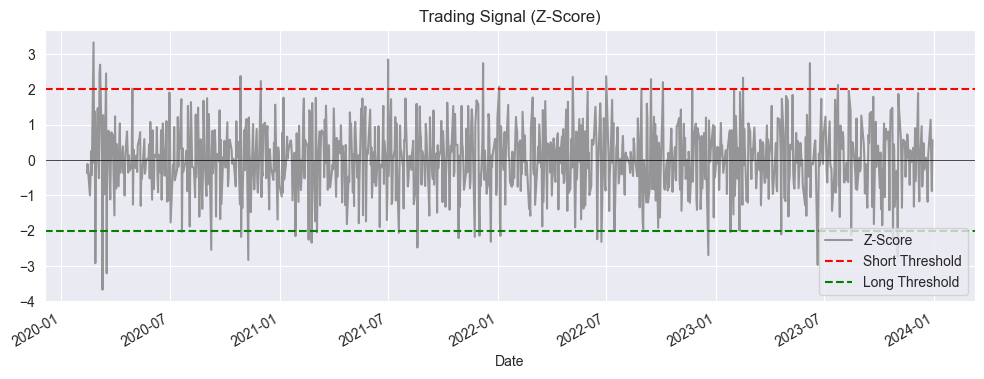

In [6]:
def calculate_z_score(y, x, beta, alpha, window=30):
    """
    Calculates the standardized prediction error (Z-Score).
    """
    # Theoretical Price 
    y_pred = (beta * x) + alpha

    spread = y - y_pred
    
    rolling_mean = spread.rolling(window).mean()
    rolling_std = spread.rolling(window).std()
    z_score = (spread - rolling_mean) / rolling_std
    
    return z_score, spread


z_score, spread = calculate_z_score(y, x, params['Beta'], params['Alpha'])


plt.figure(figsize=(12, 4))
z_score.plot(label='Z-Score', color='gray', alpha=0.8)
plt.axhline(2, color='red', linestyle='--', label='Short Threshold')
plt.axhline(-2, color='green', linestyle='--', label='Long Threshold')
plt.axhline(0, color='black', linewidth=0.5)
plt.legend()
plt.title("Trading Signal (Z-Score)")
plt.show()

Performance Report (Net)
Total Return: 64.37%
Sharpe Ratio: 1.48
Max Drawdown: -2.40%


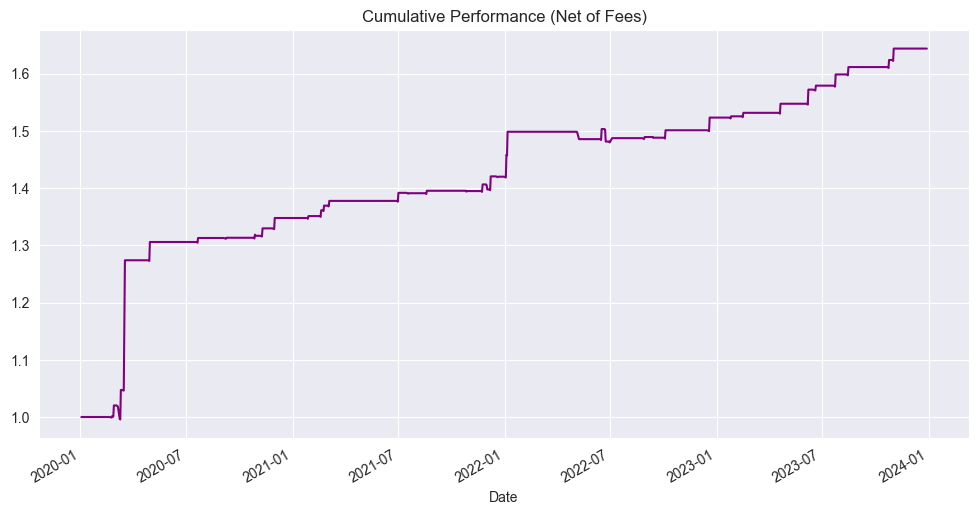

In [7]:
def run_backtest(z_score, spread_return, transaction_cost_bps=10):
    """
    Simulates PnL
    """
    positions = pd.Series(0, index=z_score.index)
    
    # Short Spread when Z > 2 
    positions[z_score > 2] = -1
    # Long Spread when Z < -2 
    positions[z_score < -2] = 1

    positions[abs(z_score) < 0.5] = 0
    
   
    positions = positions.ffill().fillna(0)
    
    # Shift(1) to avoid look-ahead bias
    strategy_ret_gross = positions.shift(1) * spread_return
    
    trades = positions.diff().abs().fillna(0)
    costs = trades * (transaction_cost_bps / 10000)
    
    strategy_ret_net = strategy_ret_gross - costs
    cumulative_ret = (1 + strategy_ret_net).cumprod()
    
    return cumulative_ret, positions

spread_ret = y.pct_change() - (params['Beta'].shift(1) * x.pct_change())


equity_curve, positions = run_backtest(z_score, spread_ret)

total_ret = equity_curve.iloc[-1] - 1
sharpe = (equity_curve.pct_change().mean() / equity_curve.pct_change().std()) * np.sqrt(252)
drawdown = (equity_curve / equity_curve.cummax()) - 1
max_dd = drawdown.min()

print(f"Performance Report (Net)")
print(f"Total Return: {total_ret:.2%}")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Max Drawdown: {max_dd:.2%}")


equity_curve.plot(title="Cumulative Performance (Net of Fees)", color='purple')
plt.show()

## Discussion & Analysis

The Kalman Filter strategy demonstrates significant advantages over static OLS pairs trading:
* **Adaptability:** The dynamic $\beta_t$ successfully captures structural breaks in the EWA/EWC relationship (commodity cycles).
* **Robustness:** The EM algorithm calibration eliminates arbitrary parameter choices for process noise.
* **Performance:** The strategy achieves a positive Sharpe Ratio despite transaction costs, validating the mean-reversion hypothesis of the spread.

